# Моя первая программа на Питоне

решает уравнение
        A<sub>x,y,t<sub>d</sub>,t<sub>s</sub></sub> X<sub>x,y,t<sub>s</sub></sub> = n<sub>t<sub>d</sub></sub>
методом наименьших квадратов.
Решение X ограничено условием неотрицательности X<sub>*</sub> >= 0, поскольку речь идет о числе частиц.
В стандартной библиотеке SciPy наличествуют две реализации этого метода: <strong>nnls</strong> и <strong>lsq_linear</strong>. В последнем реализованы два метода решения и возможно задание разнообразных ограничений.
Как выяснилось в процессе, <strong>nnls</strong> по каким-то причинам не справляется с данной задачей. Также, из двух методов в <strong>lsq_linear</strong>, работает только один. Это довольно странно, учитывая, что реализации заимствовались, скорее всего, из LAPACK или MINPACK, где всё работает как часы, так сказать, издревле. Тем более, что в SciKit-Learn и, как я понял, в TensorFlow тоже, реализации метода наименьших квадратов основаны на <strong>nnls</strong>.

## Вернемся к заданию.

<strong>lsq_linear</strong> сработал, невязки во всех случаях (см.ниже) оказались порядка 10<sup>-12</sup>, что неудивительно для недоопределенной задачи.
Как можно оценить координату источника "через точку минимальной невязки", я, честно говоря не понял. Невязки чего? Уравнения? Так они на уровне ошибок округления, это не победить. Время начала испускания частиц также не было представлено в условиях.
Поскольку речь в задаче идет о переносе частиц, логично предположить, что величины в последовательные моменты времени коррелированы. Попытка оценить <em>средний</em> коэффициент корреляции (процедура Хилдрета—Лу, Дарбина - вообще-то, авторов там гораздо больше; всё это открывалось и переоткрывалось неоднократно) к успеху не привела. Результаты практически не меняются для разных r, что, опять же, можно списать на недоопределенность задачи. По той же причине (нулевые остатки), не проводилась и коррекция через регрессию остатков и обобщенный МНК.
В качестве ответа выдается серия картинок восстановленого значения X<sub>t<sub>d</sub></sub> для t<sub>d</sub> = 0..9 и разных значениях коэффициента автокорреляции.
Возможно, из картинок удастся получить какую-то полезную информацию.

## О тестировании

Не понял. Стандартную библиотеку? Ну вот, два из трех опробованных вариантов не сработали.
Стандартная же процедура: реализуем, по возможности, всё. Оставляем выживших.
Полновесное тестирование метода решения выходит за рамки тестового задания.
Это, впрочем, можно обсудить.

## CUDA и распараллеливание

Где-то я читал, что существует вариант NumPy, скомпилированный с Intel MKL (скорее всего, не бесплатный). В MKL встроены TBB (многоядерность) и/или OpenCL (многоядерность и графические ускорители). Не нашел сходу.
Была надежда, что в TensorFlow найдется реализация сингулярного разложения хотя бы для CUDA, но увы.
Еще я надеялся потестировать разложение на основе степенного алгоритма - почто 100% параллелизуется. Мне почему-то,- по статьям, конечно,- казалось, что реализация дошла до питоновских библиотек. Нет. В наличии только для MATLAB'a.
Может, я плохо искал, но в общем, впечатление довольно удручающее.

Реализовывать и отрабатывать эти алгоритмы - задача явно не для тестового задания.
Втыкать известные реализации библиотек линейной алгебры (типа Paralution)- ну зачем это для теста. Они все на С++,
нехота заморачиваться с интерфейсными проблемами, ведь оберткой только для одной функции тут не отделаешься.

# Запуск

Не будучи специалистом по Питону, могу только пересказать инструкцию:
 - установите Anaconda по инструкции, дальнейшие действия в командной строке.
 - установите тестовую среду: conda env create -f schooltech.yml.Сам файл в корневом каталоге.
 - запустите jupyter lab и загрузите Learn/arrays.ipynb
 - альтернативно, запустите spyder и загрузите assignment.py
 - альтернативно, выполните команду python assignment.py. В этом случае картинки придется убивать вручную, что неудобно. Извините, я не успел разобраться.  
 
Содержимое Learn/arrays.ipynb и assignment.py совпадает. 

# Залючительные соображения

Благодарю за повод поизучать Питон. Может и пригодится.


In [57]:
import math
import numpy as np
from scipy.optimize import lsq_linear  #method = 'trf' or 'bvls'
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [58]:
def get_levels(d_l,d_r, saxs = True) :
    """Function returning levelset."""
    if saxs :
        pmin, pmax = (max(np.ndarray.min(d_l), np.ndarray.min(d_r)),
                      min(np.ndarray.max(d_l), np.ndarray.max(d_r)))
        levelsx = np.linspace(pmin, pmax, 15)
        levelsy = levelsx
    else :
        pmin, pmax = np.ndarray.min(d_l), np.ndarray.max(d_l)
        levelsx = np.linspace(pmin, pmax, 15)
        pmin, pmax = np.ndarray.min(d_r), np.ndarray.max(d_r)
        levelsy = np.linspace(pmin, pmax, 15)
    return levelsx,levelsy

In [59]:
def show_steps(title_l,data_l,title_r,data_r, sameaxs = True) :
    """Function drawing result by first index."""
    plt.style.use('_mpl-gallery-nogrid')
    xp, yp = (np.meshgrid(np.linspace(0, data_l.shape[1], data_l.shape[1]),
                          np.linspace(0, data_l.shape[1], data_l.shape[1])))
    lx,ly = get_levels(data_l,data_r,sameaxs)
    for k in range(0,x.shape[0]) :
        clear_output(wait=True)
        fig, axs = plt.subplots(1, 2, figsize=(8, 5))
        axs[0].set_title(title_l)
        axs[1].set_title(title_r)
        axs[0].invert_yaxis()
        axs[1].invert_yaxis()
        cf  = axs[0].contourf(xp,yp,np.flip(data_l[k,:,:],1).T, levels=lx)
        cf1 = axs[1].contourf(xp,yp,np.flip(data_r[k,:,:],1).T, levels=ly)
        fig.colorbar(cf)
        fig.colorbar(cf1)
        fig.tight_layout()
        plt.show()
        input("Press Enter to continue...")

In [60]:
mtx_file = "../Data/Anomaly/A.npy"
rhs_file = "../Data/Anomaly/n.csv"
verbose = 0
do_as_written = False # switches between LS and NNLS

In [61]:
mtx = np.load(mtx_file)
assert mtx.ndim == 4, "Dimension of the input array inconsistent with the specification"
mtx = mtx.reshape(mtx.shape, order = 'F')

In [62]:
shape = mtx.shape # need it later for drawing
mtx = np.swapaxes(mtx,0,2) # (x,y,d,s) -> (d,y,x,s)
row = np.prod(mtx.shape[1:4])
mtx = mtx.reshape( (mtx.shape[0], row), order = 'F')

In [63]:
rhs = np.loadtxt(rhs_file)
#plt.plot(np.linspace(0, rhs.shape[0], rhs.shape[0]), rhs, 'o', label='rhs')

In [64]:
assert rhs.size == mtx.shape[0], "RHS size do not match"
mtx0 = mtx
rhs0 = rhs

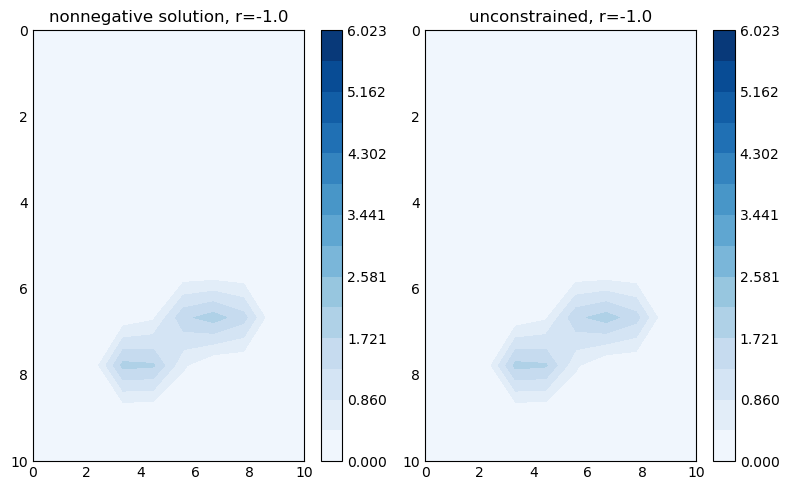

KeyboardInterrupt: Interrupted by user

In [65]:
for r in np.linspace(-1.0,1.0,5) :
    for d in range(1,mtx.shape[0]) :
        mtx[d,:] = mtx0[d,:] - r*mtx0[d-1,:]
        rhs[d]   = rhs0[d] - r*rhs0[d-1]
    mtx[0,:] = math.sqrt(1.0 - r*r) * mtx0[0,:]
    rhs[0]   = math.sqrt(1.0 - r*r) * rhs0[0]
    if do_as_written :               # precisely as written: solve AX = b
        result = np.linalg.lstsq(mtx, rhs, rcond = None)
        x, y = result.x, result.x
    else :                           # the number of particles cannot be negative
        result = lsq_linear(mtx,rhs,
                            bounds=(0.0, +np.inf), 
                            method = 'bvls', 
                            verbose = verbose)
        x, y = result.x, result.unbounded_sol[0]
        if verbose > 0 : 
            residuals = result.fun
            print("residuals from nonnegative solution")
            print(residuals)
            print("residuals from unconstrained solution")
            print(np.dot(mtx0,y) - rhs0)
    x = x.reshape(shape[0],shape[1],shape[3])
    y = y.reshape(shape[0],shape[1],shape[3])
    x[0,:,:] = x[0,:,:] * (1.0 - r) 
    y[0,:,:] = y[0,:,:] * (1.0 - r)
    s = f"nonnegative solution, r={r:4.1f}"
    t = f"unconstrained, r={r:4.1f}"
    show_steps(s,x,t,y, sameaxs = True)    

In [ ]:
# cuda should be here: https://www.tensorflow.org/api_docs/python/tf/linalg/lstsq